In [17]:
import Pkg
Pkg.activate("../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [ ]:
using Revise
using LinearAlgebra
using Statistics
using Plots


includet("TCVAR.jl")

using .TCVAR

In [ ]:
#= includet("TCVAR_model.jl")
includet("carter_kohn_algorythm.jl")
includet("model_visualisation.jl")
includet("utills.jl")
includet("gibbs_steps.jl")
includet("gibbs_sampler.jl")
includet("gibbs_var_steps.jl") =#

In [3]:
true_var_coeff = [.3 .1;  .4 .6]
true_trend_covariance =  diagm([2/10, 1/10] .^2) 

p = -0.7 * .03 * 0.01

true_cycle_covariance = [(2.)^2 p
                         p (1.)^2]



     
true_initial_trend_mean = [2., 1.]
true_initial_trend_covariance = Matrix(I, 2,2)
true_initial_cycle_mean = [.0, .0]
true_initial_cycle_covariance = [(2.)^2 0
                                 0 (1.)^2]
                                   
    
true_model = tc_var(true_var_coeff, 
                    true_trend_covariance, 
                    true_cycle_covariance, 
                    true_initial_trend_mean, 
                    true_initial_cycle_mean, 
                    true_initial_trend_covariance, 
                    true_initial_cycle_covariance)


initial_state = [.02, .008]
true_states, observations=  sample(true_model,  [2., 1., .0, .0], 100)

n_presample = 20

presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

true_states = true_states[n_presample+1:end,:]
 
  

80×4 Matrix{Float64}:
 2.3748   -0.170696     0.472325   1.35233
 2.2961   -0.0636041    1.16392   -0.204952
 2.15883  -0.0489818    0.84344   -0.866613
 2.22254  -0.207023    -3.57023   -1.29416
 2.11672  -0.0996861    1.96082   -1.54038
 2.35937   0.107853     0.8166     0.207312
 2.12069  -0.00255291  -0.750832   0.021676
 2.2627   -0.0408654   -2.71609   -1.34203
 2.08726  -0.00723225   1.12939   -1.32085
 2.49006   0.0463209    1.8174    -0.231386
 ⋮                                
 3.4374    0.0107503   -1.47071   -2.52116
 3.53751  -0.12026     -2.20691   -2.3159
 3.8137   -0.238323     0.114394  -0.555494
 3.88476  -0.315253     2.11681   -1.21237
 3.9386   -0.3234       1.92991   -1.34315
 3.999    -0.240152     0.194741   0.733654
 3.97109  -0.235315     0.662725  -0.214811
 3.37325  -0.112557    -2.28345    0.454117
 3.29348  -0.103574     0.121705  -0.230654

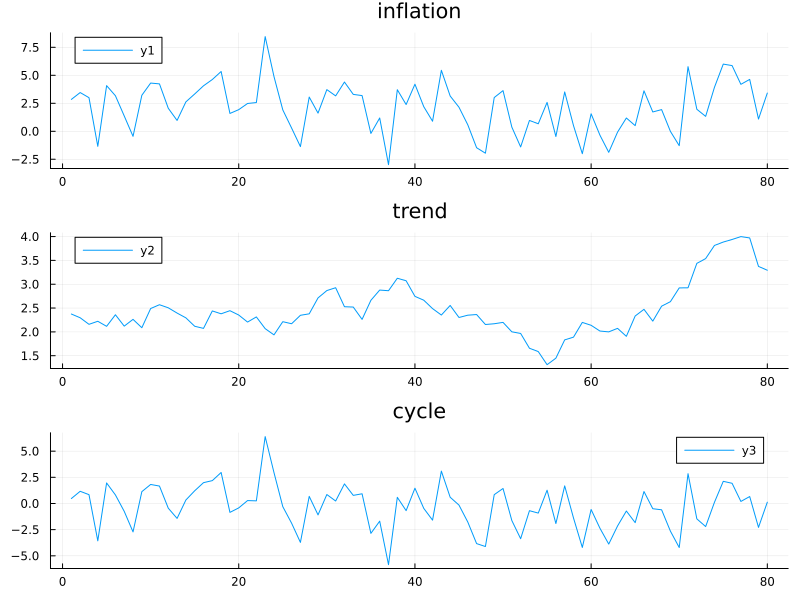

In [4]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

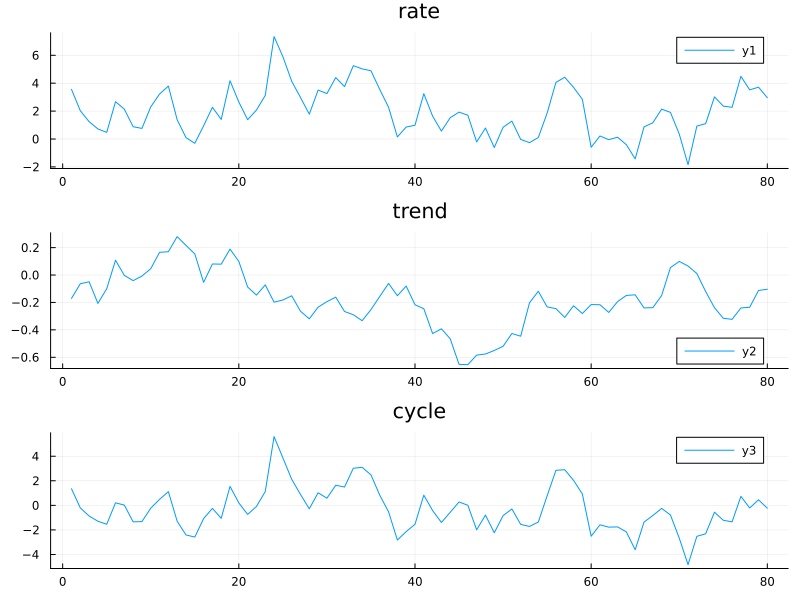

In [5]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [6]:
presample_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]]
display(presample_mean)

presample_variance = var(presample_data, dims=1)[1,:]
display(presample_variance)
display(presample_variance.^.5)


2-element Vector{Float64}:
 3.035792330313252
 0.2274619402180708

2-element Vector{Float64}:
 3.6236331179196832
 1.4184019447155891

2-element Vector{Float64}:
 1.9035842818009616
 1.1909668109211058

In [7]:
n = 2 #number of observatin variables

priors = (
        initial_trend_mean = presample_mean,
        initial_cycle_mean = zeros(2),
        initial_trend_covariance = diagm([1., 1.]),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2. /10, 1. /20].^2),
        cycle_coeff_mean = zeros(2, 2),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(presample_variance), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [3.035792330313252, 0.2274619402180708], initial_cycle_mean = [0.0, 0.0], initial_trend_covariance = [1.0 0.0; 0.0 1.0], trend_covariance_df = 100, trend_covariance_mean = [0.04000000000000001 0.0; 0.0 0.0025000000000000005], cycle_coeff_mean = [0.0 0.0; 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [3.6236331179196832 0.0; 0.0 1.4184019447155891], cycle_covariance_df = 4)

In [8]:
trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = gibs_sampler(data, priors; burnin = 5_000, n_samples = 5_000, thin=5)

trend_states_mean, trend_states_lower, trend_states_upper = compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([0.20844220197566762 1.0207437497490643; 0.850887120267888 -0.4755700963196842; … ; -1.4137527088280444 1.3670232886883567; 0.9219508565515596 0.6232083100762589], [-0.9943151871404919 -0.2920596472731002; -0.3040262533550125 -1.795450327366585; … ; -2.7587082848576534 -0.0032513656615891597; -0.453746216410503 -0.7941427306627503], [1.2819820743550077 2.276957156696678; 1.9328730987911198 0.712130129041564; … ; 0.1019339420830894 2.848169202820254; 2.4293957089596723 2.0987919192420876])

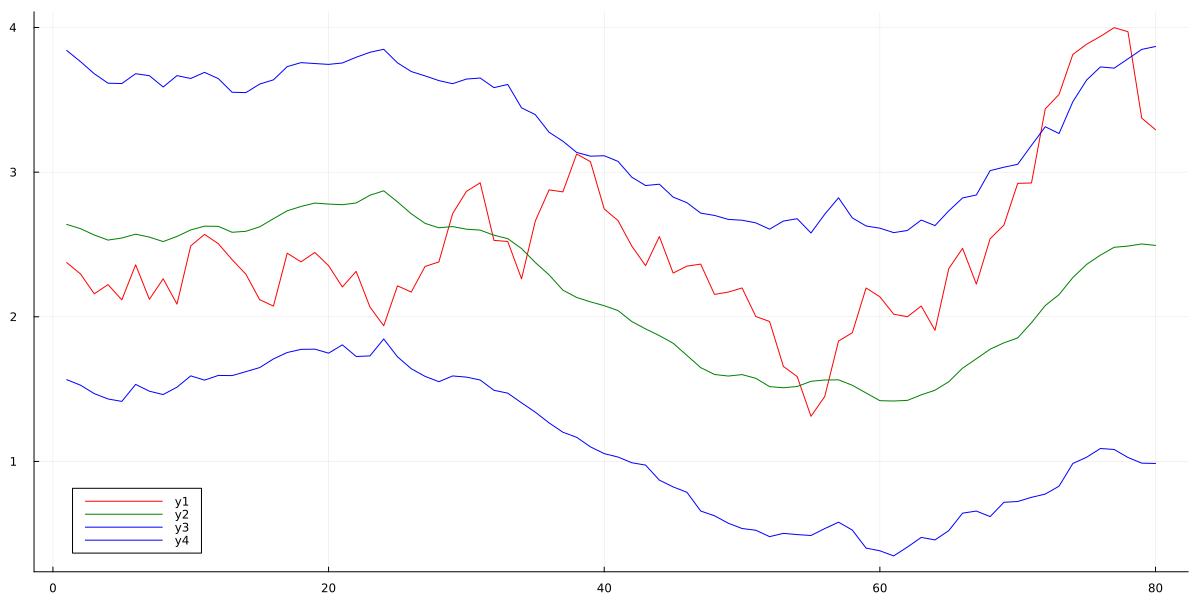

In [11]:
st = 1
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

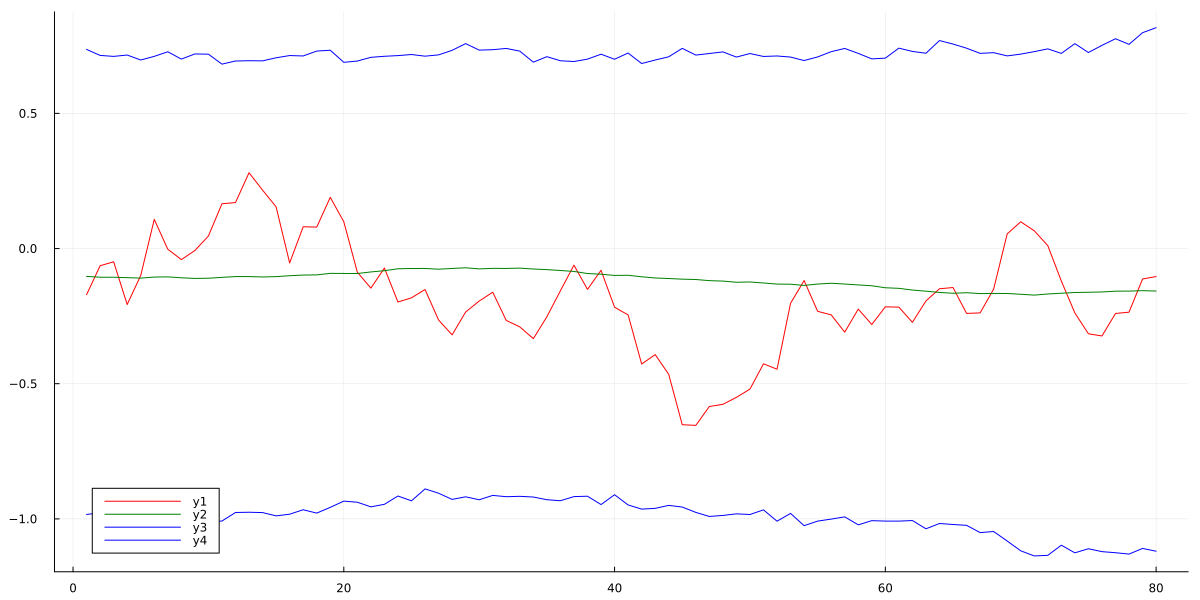

In [12]:
st = 2
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

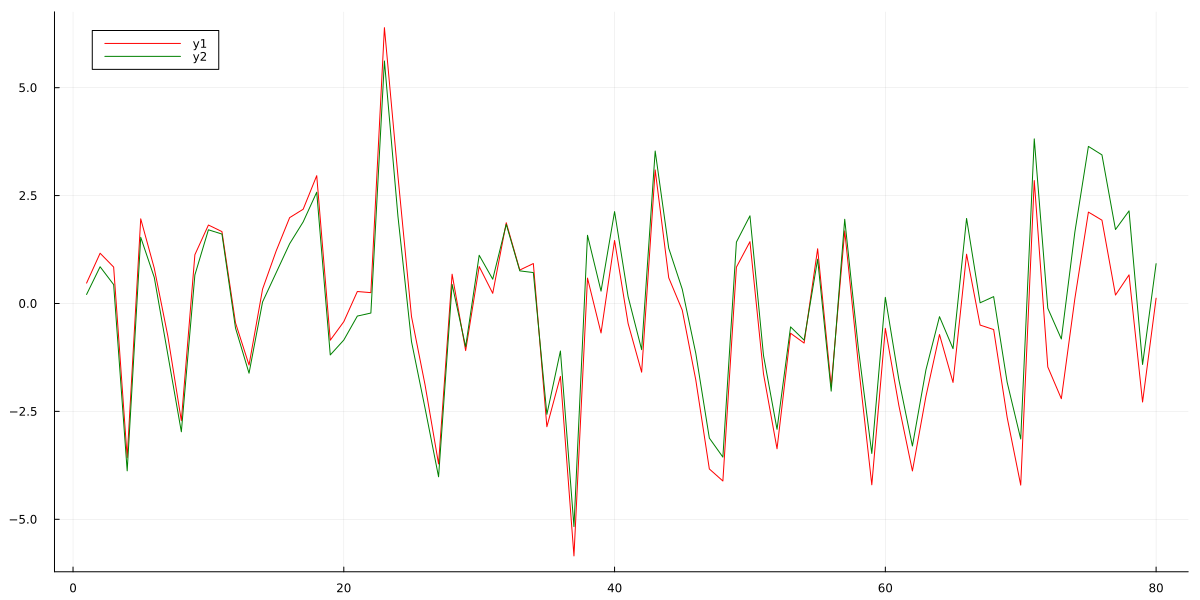

In [13]:
st=1
plot(true_states[:,3]; color="red", size= (1200, 600))
plot!(cycle_states_mean[:,st], color="green" )


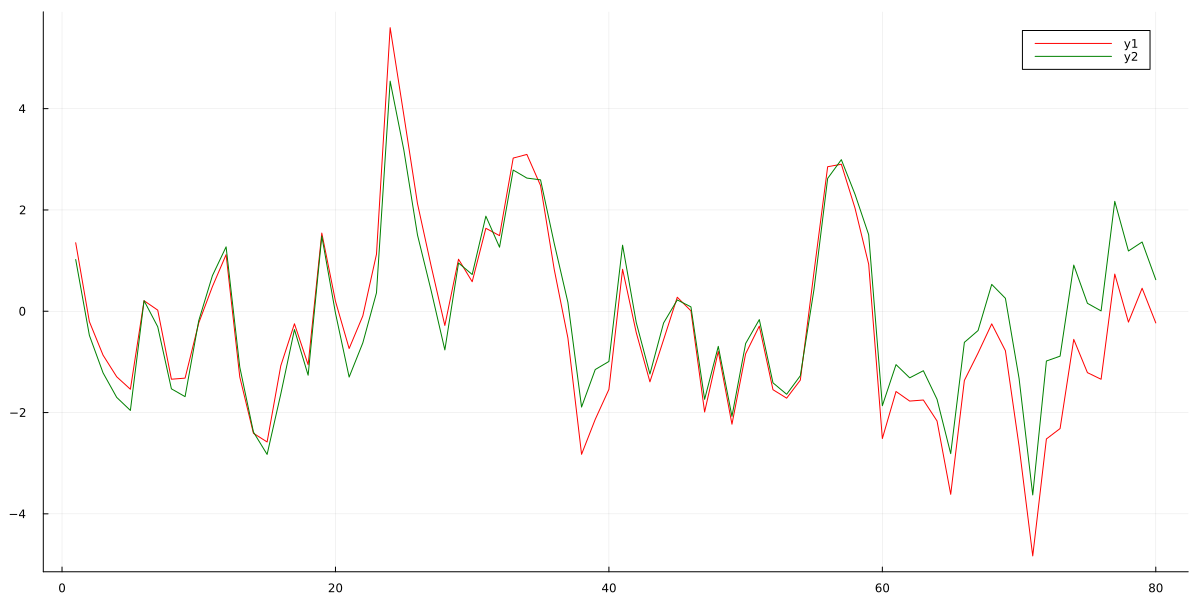

In [14]:
st = 2
plot(true_states[:,4]; color="red", size= (1200, 600))
plot!(cycle_states_mean[:,st], color="green" )

#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [15]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 0.04399770536882754
 0.008933903389440329

2-element Vector{Float64}:
 0.20975629995026976
 0.09451932812626383

In [20]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

       Στ[1]    0.0430    0.0064    0.0002   922.7742   896.9270    0.9994     ⋯
       Στ[2]    0.0000    0.0011    0.0000   969.5543   799.6889    1.0018     ⋯
       Στ[3]    0.0000    0.0011    0.0000   969.5543   799.6889    1.0018     ⋯
       Στ[4]    0.0026    0.0004    0.0000   985.7148   942.0177    1.0020     ⋯
                                                                1 column omitted


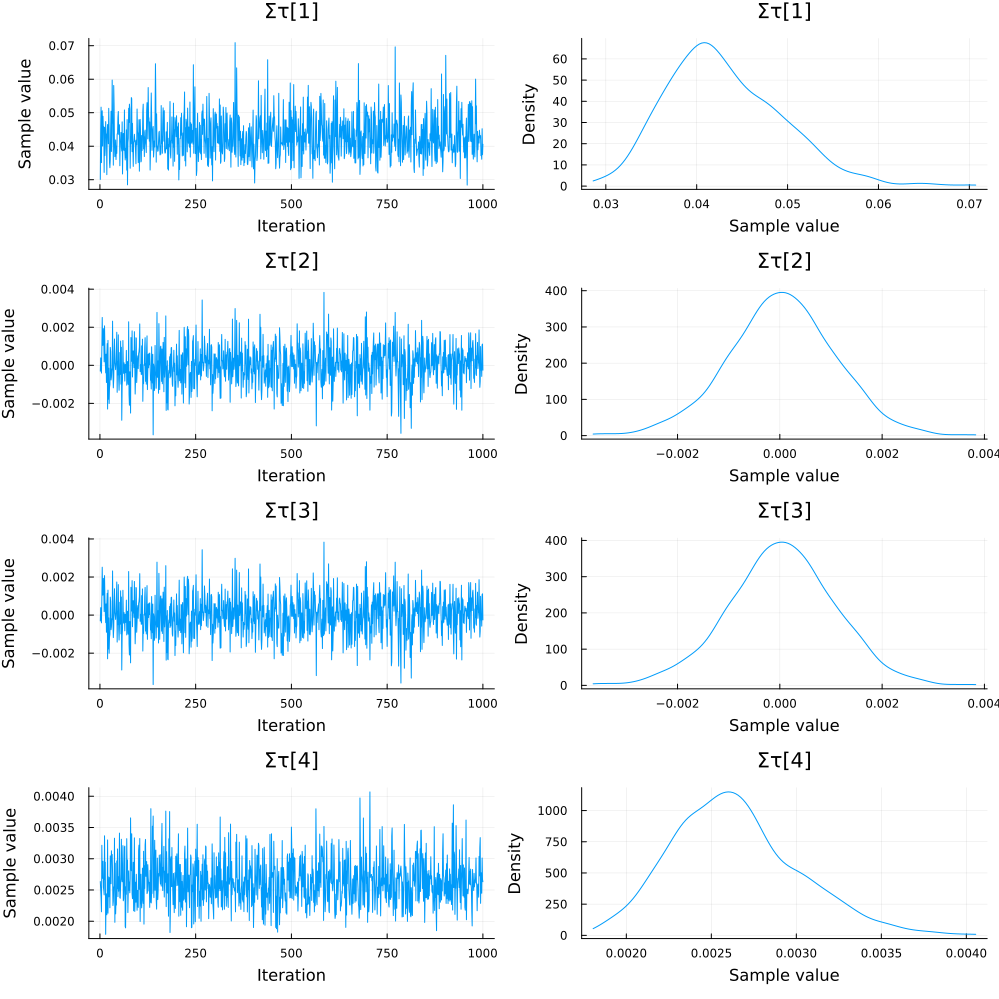

In [21]:
plot(trend_covariance_samples)

In [22]:
display(true_var_coeff)
summarystats(betas_samples)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          β1    0.1853    0.1146    0.0036   991.4183   940.7185    0.9990     ⋯
          β2   -0.1406    0.1624    0.0055   874.9459   973.3333    1.0001     ⋯
          β3    0.2985    0.0835    0.0027   952.9327   983.2831    0.9995     ⋯
          β4    0.5382    0.1108    0.0040   784.2360   869.9712    1.0043     ⋯
                                                                1 column omitted


In [23]:
display(true_cycle_covariance)
summarystats(sigmas_samples)

2×2 Matrix{Float64}:
  4.0      -0.00021
 -0.00021   1.0

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       Σc[1]    5.0154    0.8328    0.0257   1018.7073    950.6876    0.9991   ⋯
       Σc[2]    0.0915    0.3856    0.0128    896.0439   1069.0553    0.9999   ⋯
       Σc[3]    0.0915    0.3856    0.0128    896.0439   1069.0553    0.9999   ⋯
       Σc[4]    2.5225    0.4494    0.0142    944.5678   1025.2091    1.0018   ⋯
                                                                1 column omitted


uncoditional variance

In [33]:
unc_var  = (I(2) - true_var_coeff) * true_cycle_covariance
diag(unc_var) .^ .5

2-element Vector{Float64}:
 1.6733263280065844
 0.6325219363784943